<a href="https://colab.research.google.com/github/jangdain04-lab/TA_Airpods/blob/main/TA_%EC%82%AC%EB%B6%84%EB%A9%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/yeon524/kpop-lyrics-analytics/main/datasets/lyrics_by_year_1964_2023.csv"

df = pd.read_csv(url)
df.head()


,id,year,title,singer,lyric,x_rated
0,30072384,1964,워싱턴광장,정 시스터즈,NaN,False
1,8150699,1964,황혼의 에레지,최양숙,NaN,False
2,5758967,1964,물새우는 해변,권혜경,고요한 밤하늘에 별이 잠들고\n밀리는 파도소리 나혼자 들으며\n외로히 홀로 날으는 ...,False
3,4083218,1964,내일또 만납시다,금호동,하루의 일을 끝내고 돌아가는\n거리엔 사람의 물결\n하늘엔 별이 하나 둘 반짝이면\...,False
4,3622464,1964,밀짚모자 목장아가씨,박재란,시원한 밀짚모자\n포플라 그늘에\n양떼를 몰고가는\n목장의 아가씨\n연분홍 빛 입술...,False


In [ ]:
import pandas as pd
url = "https://raw.githubusercontent.com/yeon524/kpop-lyrics-analytics/main/datasets/lyrics_by_year_1964_2023.csv"
df = pd.read_csv(url)
df = df.dropna(subset=['lyric'])
df['lyric'] = df['lyric'].astype(str)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "dlckdfuf141/korean-emotion-kluebert-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

emotion_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
id2label = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happiness",
    4: "neutral",
    5: "sadness",
    6: "surprise"
}


In [ ]:
emotion_map = {
    'anger':      {'valence': -0.8, 'arousal': +0.9},
    'disgust':    {'valence': -0.9, 'arousal': +0.4},
    'fear':       {'valence': -0.8, 'arousal': +0.8},
    'happiness':  {'valence': +0.9, 'arousal': +0.7},
    'neutral':    {'valence':  0.0, 'arousal':  0.0},
    'sadness':    {'valence': -0.9, 'arousal': -0.5},
    'surprise':   {'valence': +0.2, 'arousal': +0.9}
}


In [ ]:
def get_emotion_coords(text):
    if not isinstance(text, str) or text.strip() == "" or text.lower() == "nan":
        return 0.0, 0.0

    text = text[:512]
    results = emotion_pipe(text)

    if isinstance(results, list) and len(results) == 1 and isinstance(results[0], list):
        results = results[0]

    total_valence = 0
    total_arousal = 0
    total_score = 0

    for r in results:
        label = id2label[r["label"]]
        score = r["score"]

        val = emotion_map[label]["valence"]
        aro = emotion_map[label]["arousal"]

        total_valence += val * score
        total_arousal += aro * score
        total_score += score

    return total_valence / total_score, total_arousal / total_score


In [ ]:
df['decade'] = (df['year'] // 10) * 10
df_small = df.groupby('decade').apply(lambda x: x.sample(40, replace=True))
df_small = df_small.reset_index(drop=True)

df_small['valence'], df_small['arousal'] = zip(*df_small['lyric'].apply(get_emotion_coords))


/tmp/ipython-input-266340431.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby('decade').apply(lambda x: x.sample(40, replace=True))
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
decade_emotion = df_small.groupby('decade')[['valence','arousal']].mean()
decade_emotion


,valence,arousal
decade,,
1960,0.379469,0.451553
1970,0.250409,0.368911
1980,0.648781,0.531000
1990,0.554802,0.592250
2000,0.443309,0.446613
2010,0.252304,0.486845
2020,0.000068,0.187527


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55141 (\N{HANGUL SYLLABLE HEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

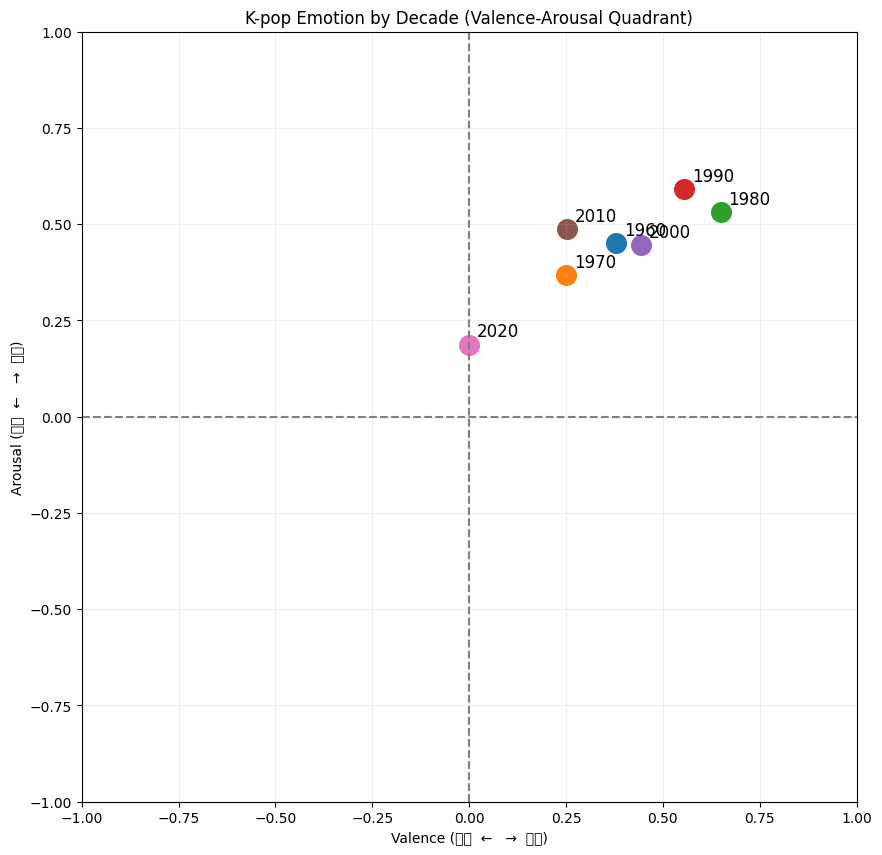

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# 중앙선 (밸런스)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# decade별 점 찍기
for decade in decade_emotion.index:
    v = decade_emotion.loc[decade, 'valence']
    a = decade_emotion.loc[decade, 'arousal']

    plt.scatter(v, a, s=200)
    plt.text(v+0.02, a+0.02, str(decade), fontsize=12)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Valence (부정  ←   →  긍정)")
plt.ylabel("Arousal (차분  ←   →  흥분)")
plt.title("K-pop Emotion by Decade (Valence-Arousal Quadrant)")
plt.grid(alpha=0.2)

plt.show()


In [ ]:
emotion_map = {
    'anger':      {'valence': -1.5, 'arousal': +1.5},
    'disgust':    {'valence': -1.2, 'arousal': +0.8},
    'fear':       {'valence': -1.3, 'arousal': +1.2},
    'sadness':    {'valence': -1.6, 'arousal': -1.0},
    'neutral':    {'valence':  0.0, 'arousal':  0.0},
    'surprise':   {'valence': +0.5, 'arousal': +1.6},
    'happiness':  {'valence': +1.6, 'arousal': +1.3}
}


In [ ]:
def get_emotion_coords_top1(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0, 0.0

    text = text[:512]

    results = emotion_pipe(text)

    # flatten (same as before)
    if isinstance(results, list) and len(results) == 1 and isinstance(results[0], list):
        results = results[0]

    # ★ 핵심: 가장 높은 확률의 label만 사용 ★
    top = max(results, key=lambda x: x['score'])
    label_id = top['label']
    label = id2label[label_id]

    val = emotion_map[label]['valence']
    aro = emotion_map[label]['arousal']

    return val, aro


In [ ]:
df['decade'] = (df['year'] // 10) * 10

# decade별 40곡 샘플링
df_small = df.groupby('decade', group_keys=False)\
             .apply(lambda x: x.sample(40, replace=True))

df_small['valence'], df_small['arousal'] = zip(*df_small['lyric'].apply(get_emotion_coords_top1))


/tmp/ipython-input-2516283574.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(40, replace=True))


In [ ]:
decade_emotion = df_small.groupby('decade')[['valence','arousal']].mean()
decade_emotion


,valence,arousal
decade,,
1960,0.2075,0.4750
1970,0.5975,0.6425
1980,1.2400,1.0375
1990,0.7475,0.8025
2000,0.9025,0.9350
2010,0.6225,0.7300
2020,0.7350,1.0475


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55141 (\N{HANGUL SYLLABLE HEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

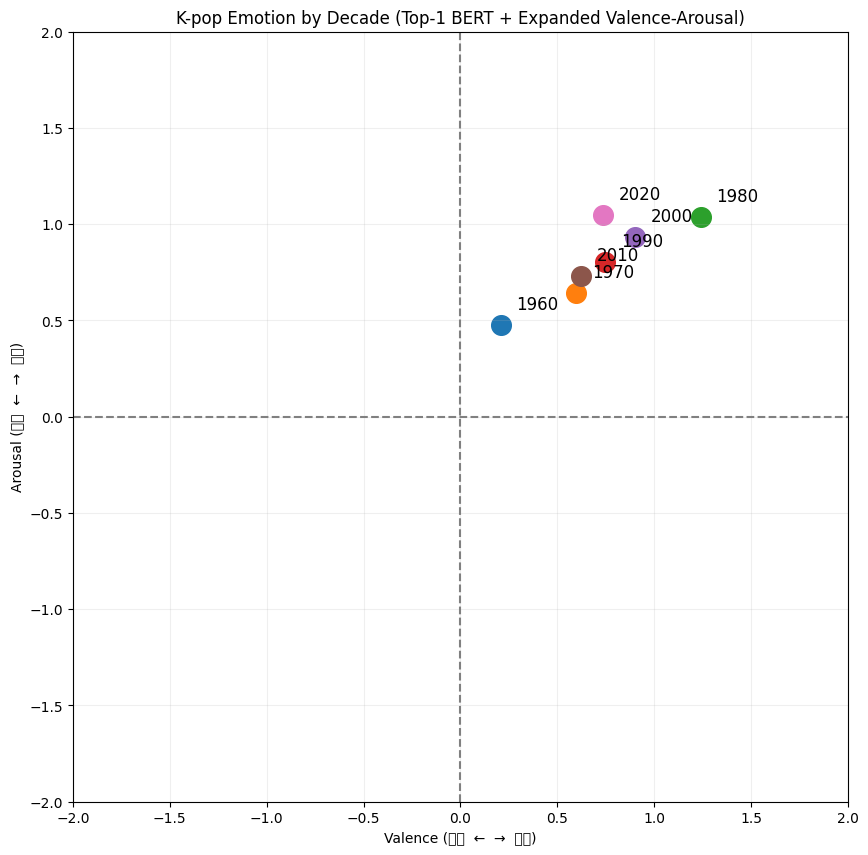

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# 축 그리기
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# 그래프 범위 확장 (감정 스케일 반영)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

for decade in decade_emotion.index:
    v = decade_emotion.loc[decade, 'valence']
    a = decade_emotion.loc[decade, 'arousal']

    plt.scatter(v, a, s=200)
    plt.text(v+0.08, a+0.08, str(decade), fontsize=12)

plt.xlabel("Valence (부정  ←  →  긍정)")
plt.ylabel("Arousal (차분  ←  →  흥분)")
plt.title("K-pop Emotion by Decade (Top-1 BERT + Expanded Valence-Arousal)")

plt.grid(alpha=0.2)
plt.show()
